In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 4,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_4_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 831)
(631390, 1)
validation
(74368, 831)
(74368, 1)
test
(85358, 831)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 10:40 - loss: 0.0133 - STD: 8.3082e-05 - MAE: 0.0866

 15/632 [..............................] - ETA: 2s - loss: 0.0146 - STD: 0.0029 - MAE: 0.0807       

 31/632 [>.............................] - ETA: 2s - loss: 0.0124 - STD: 0.0109 - MAE: 0.0702

 47/632 [=>............................] - ETA: 1s - loss: 0.0101 - STD: 0.0339 - MAE: 0.0631

 64/632 [==>...........................] - ETA: 1s - loss: 0.0084 - STD: 0.0492 - MAE: 0.0565

 81/632 [==>...........................] - ETA: 1s - loss: 0.0073 - STD: 0.0594 - MAE: 0.0524

 99/632 [===>..........................] - ETA: 1s - loss: 0.0065 - STD: 0.0659 - MAE: 0.0491

117/632 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0713 - MAE: 0.0468

134/632 [=====>........................] - ETA: 1s - loss: 0.0055 - STD: 0.0750 - MAE: 0.0451

152/632 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0436

168/632 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0425

184/632 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0416

200/632 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0840 - MAE: 0.0407

216/632 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0853 - MAE: 0.0399

232/632 [==========>...................] - ETA: 1s - loss: 0.0041 - STD: 0.0864 - MAE: 0.0392

248/632 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0876 - MAE: 0.0386

264/632 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0887 - MAE: 0.0380

280/632 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0894 - MAE: 0.0375

296/632 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0901 - MAE: 0.0371

312/632 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0908 - MAE: 0.0367

328/632 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0363

345/632 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0922 - MAE: 0.0359

363/632 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0355

380/632 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0933 - MAE: 0.0352

398/632 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0349

416/632 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0944 - MAE: 0.0347

433/632 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0948 - MAE: 0.0344

450/632 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0951 - MAE: 0.0342

467/632 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0955 - MAE: 0.0340

482/632 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0958 - MAE: 0.0338

495/632 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0337

507/632 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0963 - MAE: 0.0335

519/632 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0965 - MAE: 0.0334

532/632 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0967 - MAE: 0.0333

545/632 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0969 - MAE: 0.0332

559/632 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0970 - MAE: 0.0330

572/632 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0972 - MAE: 0.0329

584/632 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0973 - MAE: 0.0328

597/632 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0975 - MAE: 0.0327

610/632 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0977 - MAE: 0.0326

623/632 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0978 - MAE: 0.0324

632/632 [==============================] - 4s 5ms/step - loss: 0.0026 - STD: 0.0979 - MAE: 0.0324 - val_loss: 0.0017 - val_STD: 0.0799 - val_MAE: 0.0290


Epoch 2/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0017 - STD: 0.1102 - MAE: 0.0271

 14/632 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274 

 27/632 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0278

 40/632 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

 56/632 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

 73/632 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

 88/632 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

101/632 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0275

113/632 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0275

126/632 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0276

139/632 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0277

155/632 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0279

173/632 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0279

189/632 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0278

201/632 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0278

213/632 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0278

227/632 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

241/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0278

254/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0278

267/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0278

280/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

293/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

307/632 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

320/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

335/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

349/632 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

363/632 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

378/632 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

396/632 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

413/632 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

428/632 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

441/632 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

455/632 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

469/632 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

486/632 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

501/632 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

514/632 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

528/632 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

544/632 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

560/632 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

576/632 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

593/632 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

610/632 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

627/632 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

632/632 [==============================] - 2s 4ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272 - val_loss: 0.0027 - val_STD: 0.0847 - val_MAE: 0.0375


Epoch 3/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0312

 18/632 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0286 

 33/632 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0281

 49/632 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0278

 66/632 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

 84/632 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

102/632 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0272

120/632 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

137/632 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

155/632 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

173/632 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

190/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

204/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

219/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

236/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

253/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

269/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

286/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

302/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

318/632 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

334/632 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

350/632 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

367/632 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

384/632 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

401/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

418/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

435/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

451/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

467/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

483/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

499/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

515/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

531/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

547/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

564/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

580/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

596/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

612/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

628/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

632/632 [==============================] - 2s 4ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266 - val_loss: 0.0017 - val_STD: 0.0836 - val_MAE: 0.0289


Epoch 4/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0013 - STD: 0.1082 - MAE: 0.0247

 14/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1091 - MAE: 0.0261 

 27/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1080 - MAE: 0.0259

 40/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0258

 57/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0258

 74/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

 90/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

106/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

123/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0260

140/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0260

158/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0260

174/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0261

190/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0261

207/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0260

224/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

240/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260

254/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260

269/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

283/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

299/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

316/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

330/632 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

342/632 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0262

357/632 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

369/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0262

382/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

394/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

407/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

420/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

435/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

451/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

465/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

478/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

490/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

502/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

514/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

529/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

544/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

557/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

570/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

584/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

597/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

609/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

622/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

632/632 [==============================] - 3s 4ms/step - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261 - val_loss: 0.0016 - val_STD: 0.0821 - val_MAE: 0.0282


Epoch 5/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0019 - STD: 0.1121 - MAE: 0.0287

 17/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260 

 34/632 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

 47/632 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

 59/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

 71/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

 83/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

 96/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

110/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

123/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

136/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

149/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

165/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

179/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

192/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

206/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

219/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

233/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

245/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

260/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

275/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

291/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

304/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

318/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

335/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

351/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

368/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

384/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

401/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

418/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

436/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

453/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

471/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

489/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

506/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

524/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

542/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

560/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

578/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

596/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

614/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

632/632 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

632/632 [==============================] - 2s 4ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257 - val_loss: 0.0014 - val_STD: 0.0791 - val_MAE: 0.0266


Epoch 6/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0015 - STD: 0.1004 - MAE: 0.0258

 14/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0254 

 27/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0254

 42/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1044 - MAE: 0.0252

 54/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1052 - MAE: 0.0252

 67/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0251

 80/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0252

 93/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0252

106/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

119/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

131/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

144/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

160/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

173/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

186/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

200/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

216/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

232/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0253

246/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0253

258/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

271/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

285/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

301/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

316/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

330/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

344/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

358/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

372/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

385/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

398/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0253

410/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

424/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0253

439/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0253

452/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0253

464/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0253

478/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

494/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

506/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

519/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

531/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

544/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0252

556/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

570/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0252

584/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

596/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

611/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

628/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

632/632 [==============================] - 3s 4ms/step - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252 - val_loss: 0.0014 - val_STD: 0.0830 - val_MAE: 0.0264


Epoch 7/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.0987 - MAE: 0.0252

 16/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0252 

 32/632 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

 49/632 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

 66/632 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

 81/632 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

 97/632 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

113/632 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

129/632 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0252

145/632 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

161/632 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

178/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

194/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

210/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

226/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

242/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

259/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

276/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

293/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

309/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

325/632 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

341/632 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

359/632 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

377/632 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

395/632 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

412/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

429/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

446/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

463/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

481/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

499/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

516/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

532/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

549/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

565/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

581/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

596/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

613/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

630/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

632/632 [==============================] - 2s 3ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248 - val_loss: 0.0019 - val_STD: 0.0871 - val_MAE: 0.0291


Epoch 8/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0012 - STD: 0.1110 - MAE: 0.0245

 17/632 [..............................] - ETA: 1s - loss: 0.0013 - STD: 0.1085 - MAE: 0.0245 

 34/632 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1079 - MAE: 0.0243

 51/632 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1078 - MAE: 0.0243

 68/632 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1077 - MAE: 0.0242

 85/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1079 - MAE: 0.0242

101/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1080 - MAE: 0.0242

118/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1078 - MAE: 0.0241

133/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1076 - MAE: 0.0242

149/632 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1076 - MAE: 0.0241

165/632 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0241

178/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0242

192/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0243

204/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0243

216/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0244

229/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

242/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

254/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

267/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0246

280/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0246

294/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

307/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0245

320/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

333/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

348/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

361/632 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

374/632 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

389/632 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

406/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

420/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

435/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

452/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

469/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

482/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

496/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

512/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0244

525/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

538/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

553/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

566/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

580/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

597/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

610/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

625/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

632/632 [==============================] - 2s 4ms/step - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243 - val_loss: 0.0017 - val_STD: 0.0885 - val_MAE: 0.0279


Epoch 9/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0011 - STD: 0.1104 - MAE: 0.0235

 14/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241 

 31/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

 47/632 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0238

 60/632 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0237

 75/632 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

 88/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0237

100/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0237

112/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0237

124/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

137/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

152/632 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

170/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

187/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

204/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0237

222/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238

239/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238

257/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

275/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

292/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

308/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238

324/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238

340/632 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

357/632 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

375/632 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

392/632 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

409/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

425/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

441/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

457/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0239

474/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238

491/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238

508/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

525/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

542/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

559/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

575/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

591/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

607/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

623/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

632/632 [==============================] - 2s 3ms/step - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238 - val_loss: 0.0014 - val_STD: 0.0824 - val_MAE: 0.0262


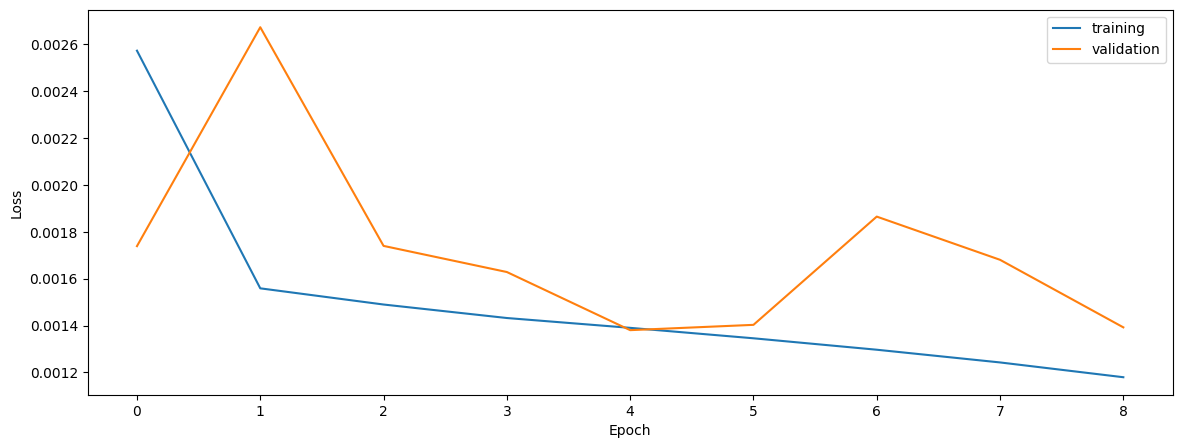

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.947331505543922
0.9581193420594509
0.9505546780250358


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.947331505543922
0.9581193420594509
0.9505546780250358


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9537147439725968
0.9609418311881063
0.9623518682574583


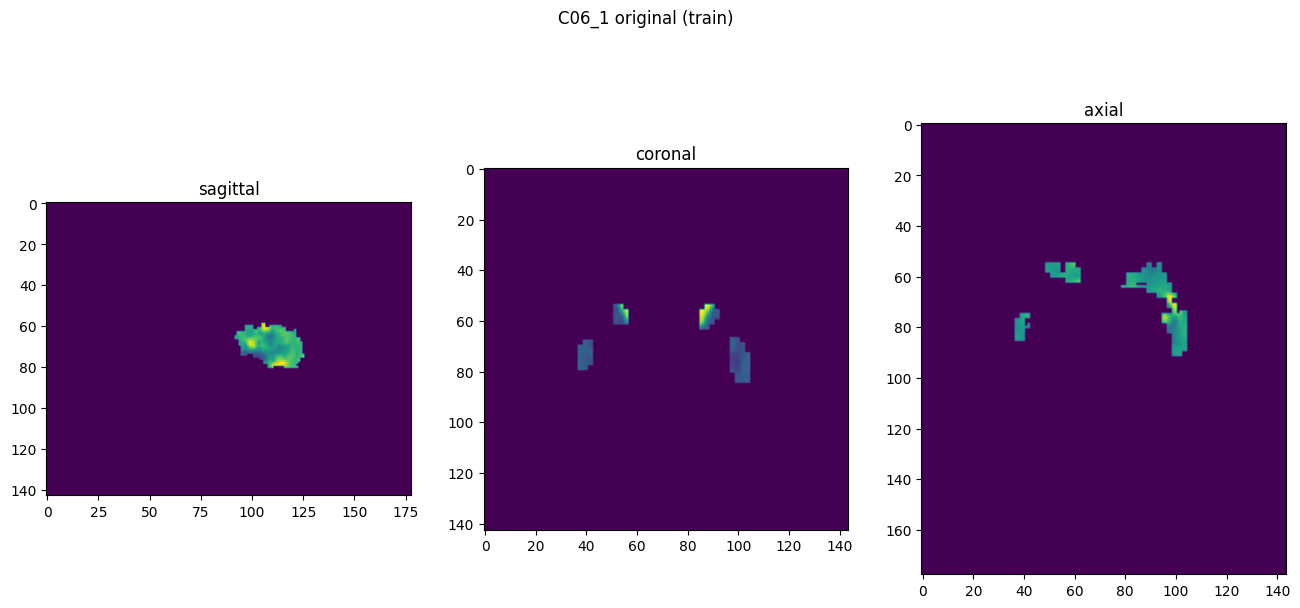

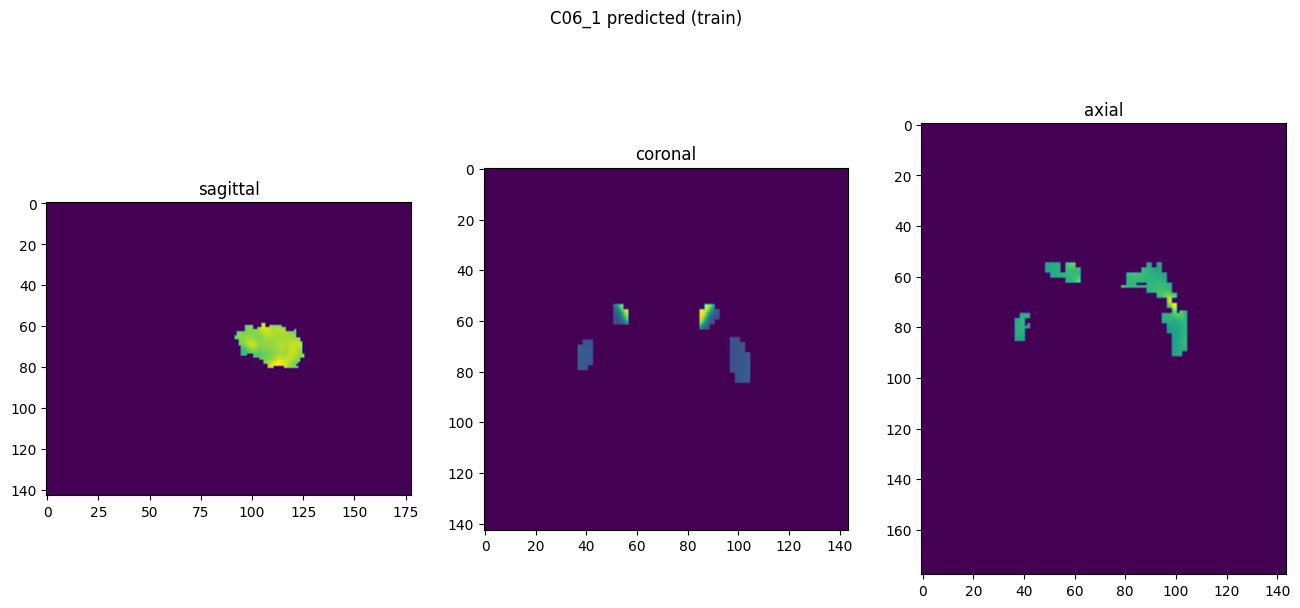

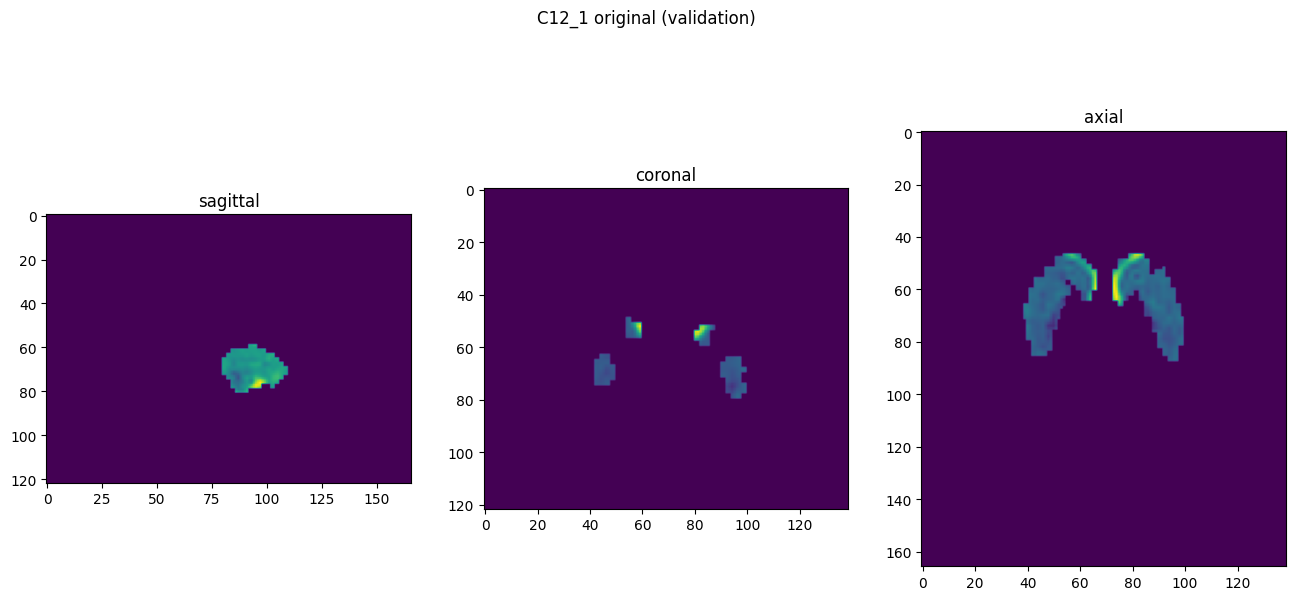

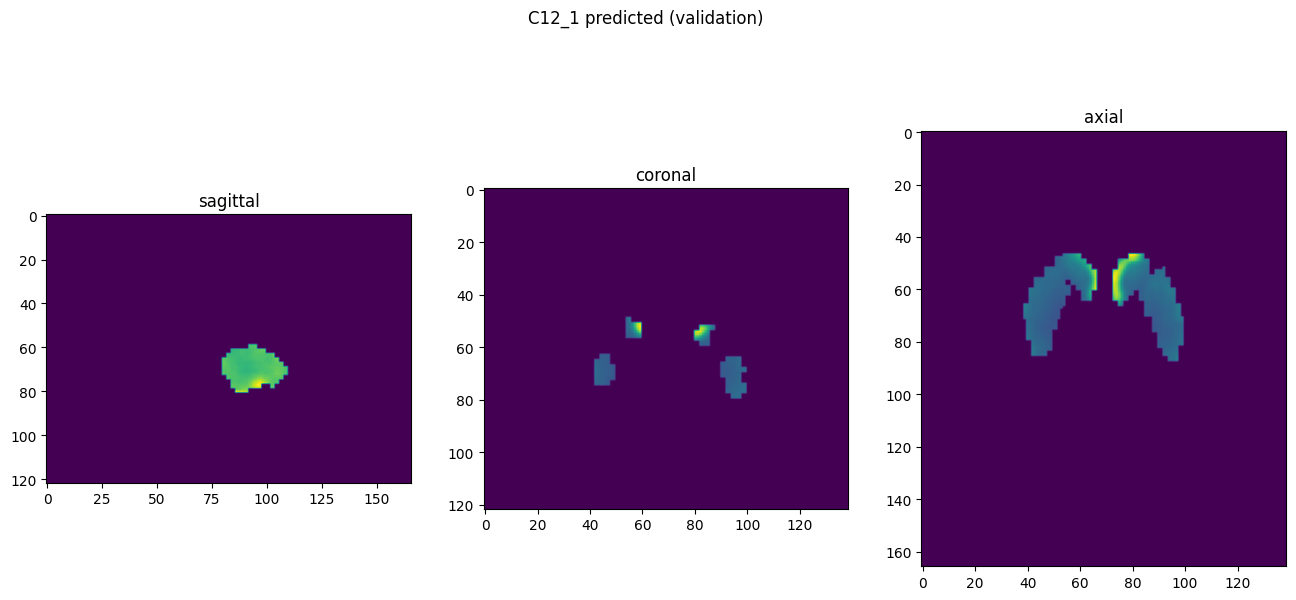

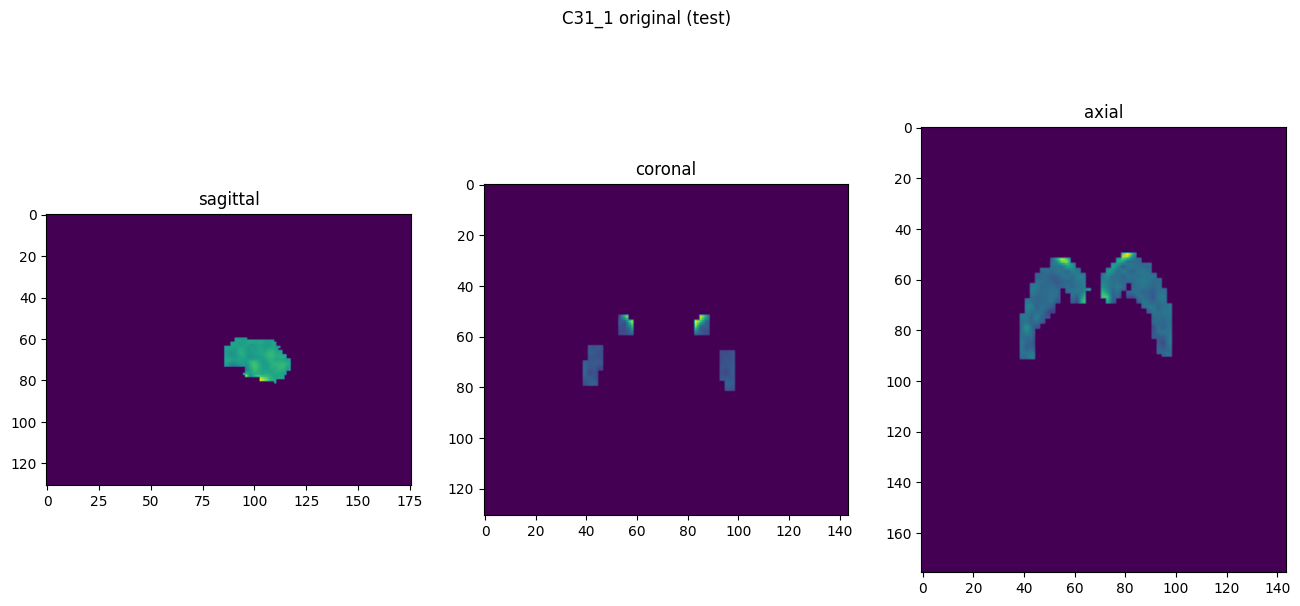

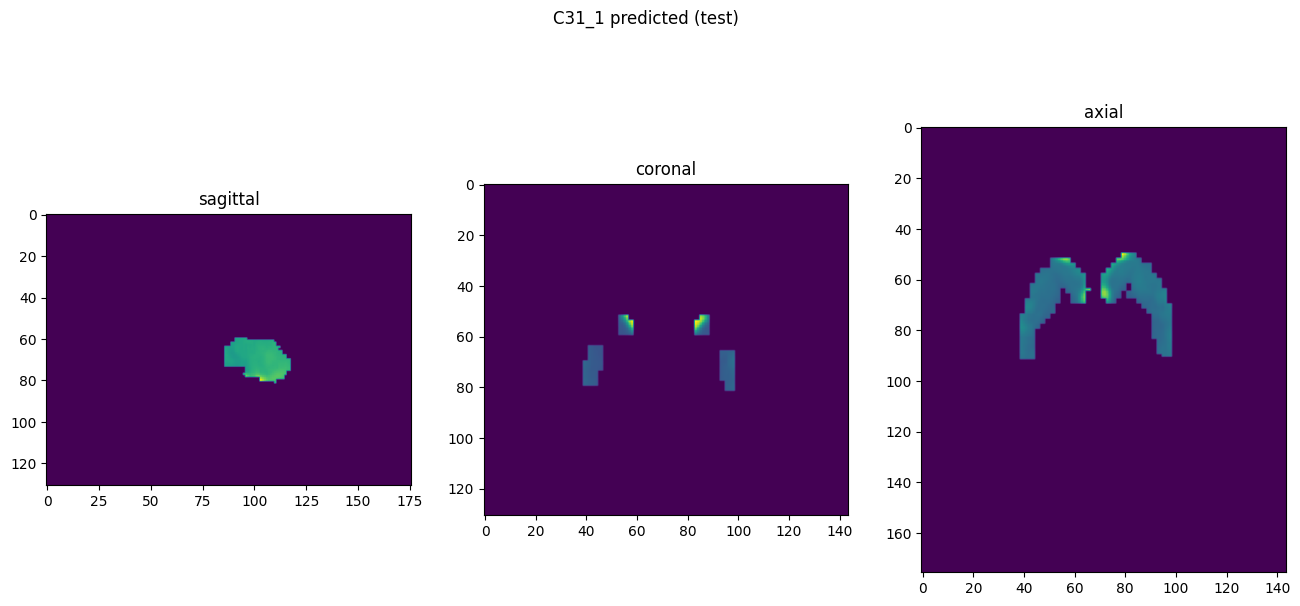

In [10]:
showResults(model, gen, threshold=None, background=False)